In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.impute import SimpleImputer
import sklearn
sklearn.set_config(transform_output="pandas")
from imblearn.pipeline import Pipeline 




In [ ]:
# This section is standardised to enable judges to automatically swap the url link of your test dataset with that of the hold-out dataset
# You must load your data exactly as specified below.
# On upload, the existence of the below lines of code is validated, verbatim, before your notebook is accepted.
URL_TRAIN = "Data/TrainData.csv"
URL_TEST  = "Data/TestData.csv"
dfTrain = pd.read_csv(URL_TRAIN) # stream straight from the link
dfTest  = pd.read_csv(URL_TEST) # stream straight from the link
# assert {"LeadID","VehicleSoldProbability"} <= dfTrain.columns                                           #causes error#
# print("Data successfully loaded:", dfTrain.shape, dfTest.shape)

In [3]:
print(dfTest.head())


                             CustomerID    LeadID     DTLeadCreated  \
0  4A689672-0844-464F-BA73-EEDF4F4832F4  11187548  2025-02-15 14:49   
1  2C961B46-7B19-4643-90EF-25208500FDCC  11187684  2025-02-15 15:16   
2  596E3072-1C63-473A-99E8-23D01272BD40  11187917  2025-02-15 15:55   
3  824965E7-A7DA-4C45-A754-D685C58C20F9  11187948  2025-02-15 16:03   
4  530AF4BD-9080-4E63-A175-30E648715D08  11188151  2025-02-15 16:42   

    DTLeadAllocated                            Dealer  \
0  2025-02-17 11:58                        Kia Menlyn   
1  2025-02-15 15:16        Renault Northcliff - 70045   
2  2025-02-15 15:55               Motus MG Roodepoort   
3  2025-02-17 10:11   Lindsay Saker VW East Rand Mall   
4  2025-02-15 16:42  Nelspruit Multifranchise - 70024   

                     LeadSource    LeadType  Seek InterestMake  \
0                     KIA.CO.ZA       Other   New          KIA   
1    RR-Dealer Facebook-Renault    Facebook   New      Renault   
2            Dealer Facebook-MG 

In [4]:
missing_counts = dfTrain.isnull().sum()
print(missing_counts)


CustomerID                      0
LeadID                          0
DTLeadCreated                   0
DTLeadAllocated                 0
Dealer                          0
LeadSource                      0
LeadType                        0
Seek                            0
InterestMake                 1230
InterestModel                6845
OBSFullName                     0
OBSEmail                     7787
Domain                       7787
CellPrefix                      0
CellPhoneNoLength               0
HourOfEnquiry                   0
DayOfEnquiry                    0
InFinanceProcessSystemApp       0
FinanceApplied                  0
FinanceApproved                 0
VehicleSold                     0
dtype: int64


In [5]:
unique_counts = dfTrain.nunique()
print(unique_counts)


CustomerID                   57466
LeadID                       73286
DTLeadCreated                51024
DTLeadAllocated              39160
Dealer                         115
LeadSource                     450
LeadType                         9
Seek                             2
InterestMake                   353
InterestModel                 4684
OBSFullName                   5549
OBSEmail                     16296
Domain                        3260
CellPrefix                     105
CellPhoneNoLength               14
HourOfEnquiry                   24
DayOfEnquiry                    31
InFinanceProcessSystemApp        2
FinanceApplied                   2
FinanceApproved                  2
VehicleSold                      2
dtype: int64


In [6]:
#rint(dfTest.describe())
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73286 entries, 0 to 73285
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   CustomerID                 73286 non-null  object
 1   LeadID                     73286 non-null  int64 
 2   DTLeadCreated              73286 non-null  object
 3   DTLeadAllocated            73286 non-null  object
 4   Dealer                     73286 non-null  object
 5   LeadSource                 73286 non-null  object
 6   LeadType                   73286 non-null  object
 7   Seek                       73286 non-null  object
 8   InterestMake               72056 non-null  object
 9   InterestModel              66441 non-null  object
 10  OBSFullName                73286 non-null  object
 11  OBSEmail                   65499 non-null  object
 12  Domain                     65499 non-null  object
 13  CellPrefix                 73286 non-null  object
 14  CellPh

In [7]:
# Data processing and Cleaning 
def preprocess_data(df, is_train):
    
    # Columns to be Removed Columns
    leak_cols = ['InFinanceProcessSystemApp', 'FinanceApplied', 'FinanceApproved']
    drop_cols = ['OBSFullName', 'OBSEmail', 'LeadID', 'DTLeadCreated', 'DTLeadAllocated','HourOfEnquiry','ResponseTimeBucket','InterestModel','Domain','CellPhoneNoLength','CustomerID']
    
    df['DTLeadCreated'] = pd.to_datetime(df['DTLeadCreated'], errors='coerce')
    df['DTLeadAllocated'] = pd.to_datetime(df['DTLeadAllocated'], errors='coerce')
    #df['LeadAllocationDelayMins'] = (df['DTLeadAllocated'] - df['DTLeadCreated']).dt.total_seconds() / 60
    df['IsValidCell'] = (df['CellPhoneNoLength'] == 10).astype(int)
    df['DayOfEnquiry'] = df['DayOfEnquiry'].astype('object')
    df['CellPhoneNoLength'] = df['CellPhoneNoLength'].astype('object')
    df['IsLuxuryBrand'] = df['InterestMake'].isin(['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Jaguar']).astype(int)
        # Calculate response time in hours
    df['ResponseTimeHours'] = (df['DTLeadAllocated'] - df['DTLeadCreated']).dt.total_seconds() / 3600

    # Define Response Time Buckets (up to 5 days)
    def response_time_bucket(hours):
        if pd.isna(hours):
            return 'No Allocation'
        elif hours <= 24:
            return '0-24h'
        elif hours <= 48:
            return '24-48h'
        elif hours <= 72:
            return '48-72h'
        elif hours <= 96:
            return '72-96h'
        elif hours <= 120:
            return '96-120h'
        else:
            return '>120h'

    #Apply bucketing
    df['ResponseTimeBucket'] = df['ResponseTimeHours'].apply(response_time_bucket)

    
    
    #Fill missing data with 'missing' -categorty
    df = df.fillna("Missing")
    df = df.drop(columns=drop_cols+leak_cols, errors='ignore')

    return df

In [8]:
# Show dataframes
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)      
pd.set_option('display.max_colwidth', None) 
preprocess_data(dfTrain, is_train=False).head(2)



C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")


,Dealer,LeadSource,LeadType,Seek,InterestMake,CellPrefix,DayOfEnquiry,VehicleSold,IsValidCell,IsLuxuryBrand,ResponseTimeHours
0,Motus Chery Germiston,DEALER FACEBOOK,Facebook,New,Chery,61,15,0,1,0,45.216667
1,Renault Northcliff - 70045,RR-Dealer Facebook-Renault,Facebook,New,Renault,83,15,0,1,0,0.000000


In [9]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)      
pd.set_option('display.max_colwidth', None) 
preprocess_data(dfTest, is_train=False).head(2)


C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")


,Dealer,LeadSource,LeadType,Seek,InterestMake,CellPrefix,DayOfEnquiry,IsValidCell,IsLuxuryBrand,ResponseTimeHours
0,Kia Menlyn,KIA.CO.ZA,Other,New,KIA,78,15,1,0,45.15
1,Renault Northcliff - 70045,RR-Dealer Facebook-Renault,Facebook,New,Renault,66,15,1,0,0.00


In [10]:
preprocess_data(dfTrain,False).info()

C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73286 entries, 0 to 73285
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dealer             73286 non-null  object 
 1   LeadSource         73286 non-null  object 
 2   LeadType           73286 non-null  object 
 3   Seek               73286 non-null  object 
 4   InterestMake       73286 non-null  object 
 5   CellPrefix         73286 non-null  object 
 6   DayOfEnquiry       73286 non-null  int64  
 7   VehicleSold        73286 non-null  int64  
 8   IsValidCell        73286 non-null  int64  
 9   IsLuxuryBrand      73286 non-null  int64  
 10  ResponseTimeHours  73286 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 6.2+ MB


C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")


LeadSource           0.1433
InterestMake         0.1081
Dealer               0.0850
LeadType             0.0656
CellPrefix           0.0569
Seek                 0.0490
IsValidCell          0.0087
IsLuxuryBrand        0.0023
DayOfEnquiry         0.0014
ResponseTimeHours   -0.0126
dtype: float64


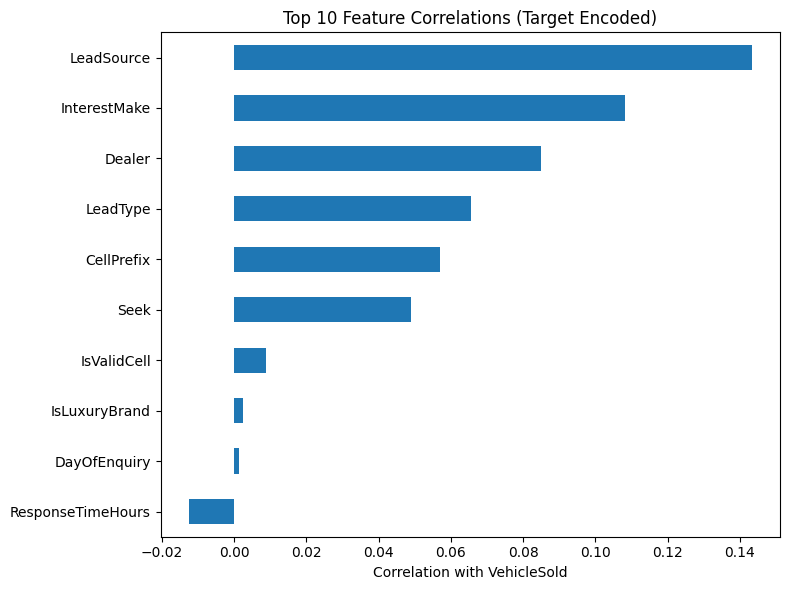

In [11]:

def TargetEncodeCorrelate(df, binary_target):
    df_encoded = df.copy()
    correlations = {}


    categorical_columns = df.select_dtypes(include=['object']).columns

    for col in categorical_columns:
   
        target_means = df.groupby(col)[binary_target].mean()
        df_encoded[col] = df[col].map(target_means)

   
    for col in df_encoded.columns:
        if col == binary_target:
            continue
        try:
            corr = df_encoded[col].corr(df_encoded[binary_target])
            correlations[col] = round(corr, 4)
        except:
            correlations[col] = None

    return pd.Series(correlations).sort_values(ascending=False)

cor_encoded = TargetEncodeCorrelate(preprocess_data(dfTrain,False), binary_target='VehicleSold')
print(cor_encoded)

import matplotlib.pyplot as plt

cor_encoded.head(20).plot(kind='barh', figsize=(8,6), title='Top 10 Feature Correlations (Target Encoded)')
plt.gca().invert_yaxis()
plt.xlabel('Correlation with VehicleSold')
plt.tight_layout()
plt.show()



C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1787545873.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


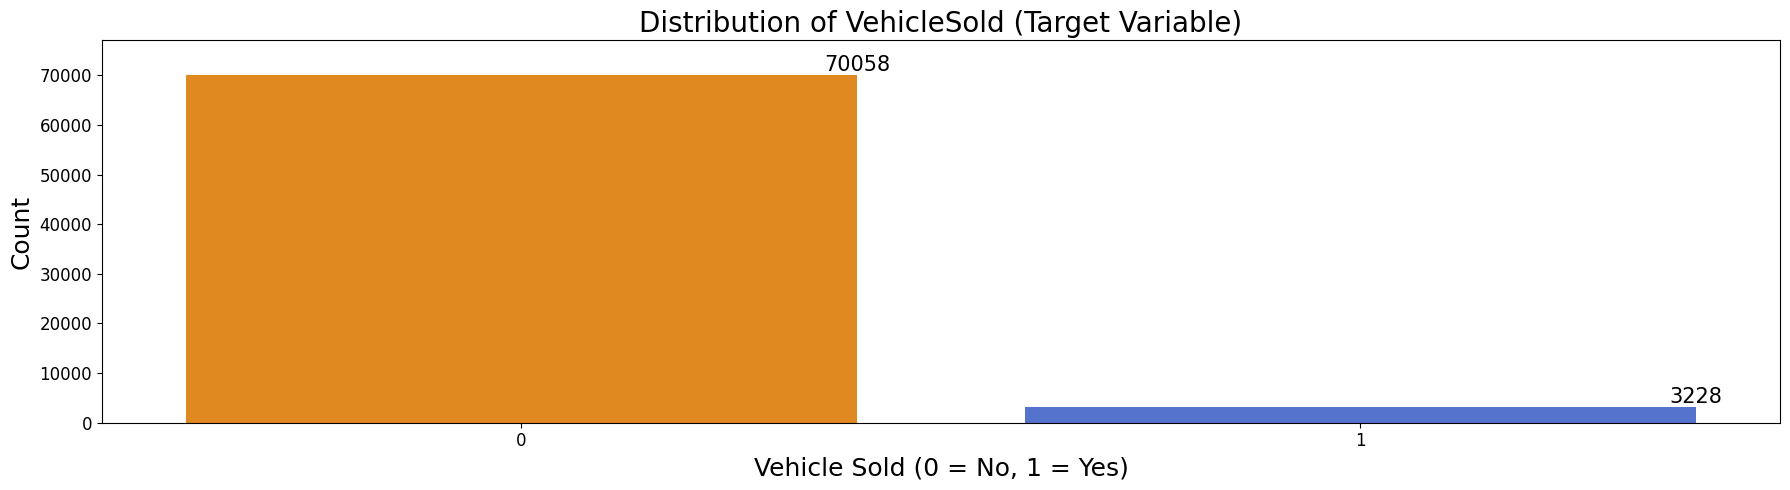

In [12]:

plt.figure(figsize=(18, 5))

ax = sns.countplot(
    x='VehicleSold',
    data=dfTrain,
    palette=["darkorange", "royalblue"]
)

ax.set_title("Distribution of VehicleSold (Target Variable)", fontsize=20)
plt.xlabel("Vehicle Sold (0 = No, 1 = Yes)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: set y-limit (adjust based on your data)
ax.set(ylim=(0, dfTrain['VehicleSold'].value_counts().max() * 1.1))

# Add count annotations on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 1, height),
        ha='center',
        va='bottom',
        color='black',
        fontsize=15
    )

plt.tight_layout()
plt.show()


In [13]:
def smoothed_target_encoding_train_test(X_train, y_train, X_test, cat_cols, smoothing=20):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    global_mean = y_train.mean()

    for col in cat_cols:
        # Compute category statistics from train set only
        stats = X_train.groupby(col)[y_train.name].agg(['count', 'mean'])
        counts = stats['count']
        means = stats['mean']

        smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)

        # Map to both train and test sets
        X_train_encoded[col] = X_train[col].map(smooth).fillna(global_mean)
        X_test_encoded[col] = X_test[col].map(smooth).fillna(global_mean)

    return X_train_encoded, X_test_encoded


In [14]:


# Step 0: Preprocess original data
TrainData = preprocess_data(dfTrain, is_train=True)
TestData = preprocess_data(dfTest, is_train=False)
BinaryTarget = dfTrain['VehicleSold']

Categorical_Features = TrainData.select_dtypes(include='object').columns.tolist()

X_train_encoded, X_val_encoded = smoothed_target_encoding_train_test(
    TrainData, BinaryTarget, TestData, Categorical_Features, smoothing=10
)

# Drop target if it was included in the feature
if 'VehicleSold' in X_train_encoded.columns:
    X_train_encoded = X_train_encoded.drop('VehicleSold', axis=1)


numeric_passthrough = SimpleImputer(strategy="constant", fill_value=0)

#Calculate class imbalance scale for balancing using scale_pos_weight *NB*
num_neg = (BinaryTarget == 0).sum()
num_pos = (BinaryTarget == 1).sum()
scale_pos_weight = num_neg / num_pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

#mModel paramet list
param_dist = {
    'modeling__n_estimators': randint(100, 500),
    'modeling__max_depth': randint(3, 10),
    'modeling__learning_rate': uniform(0.01, 0.2),
    'modeling__subsample': uniform(0.5, 0.5),
    'modeling__colsample_bytree': uniform(0.3, 0.7),
    'modeling__reg_alpha': uniform(0, 2),
    'modeling__reg_lambda': uniform(0, 5),
    'modeling__gamma': uniform(0, 5)
}

#Initialize model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42,
    n_estimators=151,
    max_depth=3,
    learning_rate=0.08272592047585879,
    colsample_bytree=0.6631534352203563,
    gamma=3.515094794475889,
    scale_pos_weight=scale_pos_weight
)
from imblearn.under_sampling import RandomUnderSampler


model_pipeline = Pipeline([
  
    ('modeling', model)
])
#Cross validation
accuracy = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cv_scores = cross_validate(
    estimator=model_pipeline,
    X=X_train_encoded,
    y=BinaryTarget,
    scoring=accuracy,
    cv=cv,
    return_train_score=True,
    return_estimator=True
)

# Summary/Evaluation
mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])

print(f"✅ CV Accuracy: {mean_cv:.3f} ± {std_cv:.3f}")
print(f"🕒 Fit time: {fit_time:.2f}s, Score time: {score_time:.2f}s")


C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")
C:\Users\morri\AppData\Local\Temp\ipykernel_14388\1158314729.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Missing")


scale_pos_weight: 21.70


c:\Users\morri\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

✅ CV Accuracy: 0.576 ± 0.005
🕒 Fit time: 0.23s, Score time: 0.01s


In [15]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)      
pd.set_option('display.max_colwidth', None) 
X_train_encoded.head(10)


,Dealer,LeadSource,LeadType,Seek,InterestMake,CellPrefix,DayOfEnquiry,IsValidCell,IsLuxuryBrand,ResponseTimeHours
0,0.039849,0.037291,0.030976,0.035426,0.064807,0.049833,15,1,0,45.216667
1,0.045139,0.042536,0.030976,0.035426,0.042300,0.057472,15,1,0,0.000000
2,0.036915,0.078555,0.047491,0.035426,0.069138,0.041291,15,1,0,42.166667
3,0.050508,0.104446,0.057569,0.035426,0.058485,0.042744,15,1,0,0.033333
4,0.036915,0.011944,0.017390,0.035426,0.042300,0.042744,15,1,0,0.000000
5,0.011905,0.032010,0.047491,0.035426,0.053184,0.038890,15,1,0,44.133333
6,0.045139,0.042536,0.030976,0.035426,0.042300,0.042744,15,1,0,0.000000
7,0.057980,0.008907,0.047491,0.055786,0.085673,0.035161,15,1,0,2.416667
8,0.047104,0.063483,0.054102,0.055786,0.053033,0.038350,15,1,0,43.033333
9,0.022326,0.037291,0.030976,0.035426,0.064807,0.050909,15,1,0,44.333333


In [16]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)      
pd.set_option('display.max_colwidth', None) 
X_train_encoded.head(10)

,Dealer,LeadSource,LeadType,Seek,InterestMake,CellPrefix,DayOfEnquiry,IsValidCell,IsLuxuryBrand,ResponseTimeHours
0,0.039849,0.037291,0.030976,0.035426,0.064807,0.049833,15,1,0,45.216667
1,0.045139,0.042536,0.030976,0.035426,0.042300,0.057472,15,1,0,0.000000
2,0.036915,0.078555,0.047491,0.035426,0.069138,0.041291,15,1,0,42.166667
3,0.050508,0.104446,0.057569,0.035426,0.058485,0.042744,15,1,0,0.033333
4,0.036915,0.011944,0.017390,0.035426,0.042300,0.042744,15,1,0,0.000000
5,0.011905,0.032010,0.047491,0.035426,0.053184,0.038890,15,1,0,44.133333
6,0.045139,0.042536,0.030976,0.035426,0.042300,0.042744,15,1,0,0.000000
7,0.057980,0.008907,0.047491,0.055786,0.085673,0.035161,15,1,0,2.416667
8,0.047104,0.063483,0.054102,0.055786,0.053033,0.038350,15,1,0,43.033333
9,0.022326,0.037291,0.030976,0.035426,0.064807,0.050909,15,1,0,44.333333


In [17]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)      
pd.set_option('display.max_colwidth', None) 
X_val_encoded.head(10)

,Dealer,LeadSource,LeadType,Seek,InterestMake,CellPrefix,DayOfEnquiry,IsValidCell,IsLuxuryBrand,ResponseTimeHours
0,0.065223,0.051925,0.047491,0.035426,0.069138,0.039413,15,1,0,45.150000
1,0.045139,0.042536,0.030976,0.035426,0.042300,0.050909,15,1,0,0.000000
2,0.030447,0.015156,0.030976,0.035426,0.018190,0.044478,15,1,0,0.000000
3,0.078886,0.055883,0.065276,0.055786,0.058485,0.038350,15,1,0,42.133333
4,0.029117,0.008907,0.047491,0.055786,0.085673,0.035161,15,1,0,0.000000
5,0.045139,0.037291,0.030976,0.055786,0.042300,0.040046,15,1,0,0.000000
6,0.051657,0.045524,0.030976,0.035426,0.042300,0.039413,15,1,0,0.000000
7,0.057980,0.069828,0.057569,0.055786,0.058737,0.065515,15,1,0,0.000000
8,0.036851,0.042536,0.030976,0.035426,0.042300,0.044478,15,1,0,0.000000
9,0.044207,0.057416,0.055007,0.055786,0.058485,0.041291,15,1,0,39.333333


In [18]:
# #hyper parameter tuning to get best training parameters for model
# random_search = RandomizedSearchCV(
#     estimator=model_pipeline,
#     param_distributions=param_dist,
#     n_iter=30,  
#     scoring='average_precision',
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train_encoded, BinaryTarget)

In [19]:


lead_ids = dfTest['LeadID']
model_pipeline.fit(X_train_encoded, BinaryTarget)           #fit data to model
y_pred = model_pipeline.predict_proba(X_val_encoded)[:, 1]  # Get probability of class 1

submission = pd.DataFrame({
    'LeadID': lead_ids,
    'VehicleSoldProbability': y_pred
})
submission.to_csv("submission_v1XGB.csv", index=False, sep=',')
print("✅ Submission saved!")


c:\Users\morri\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Submission saved!


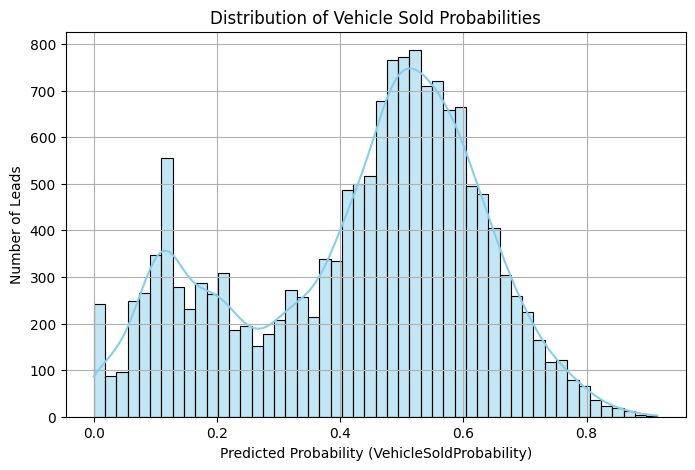

In [20]:


#chreck model confidence
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Vehicle Sold Probabilities')
plt.xlabel('Predicted Probability (VehicleSoldProbability)')
plt.ylabel('Number of Leads')
plt.grid(True)
plt.show()


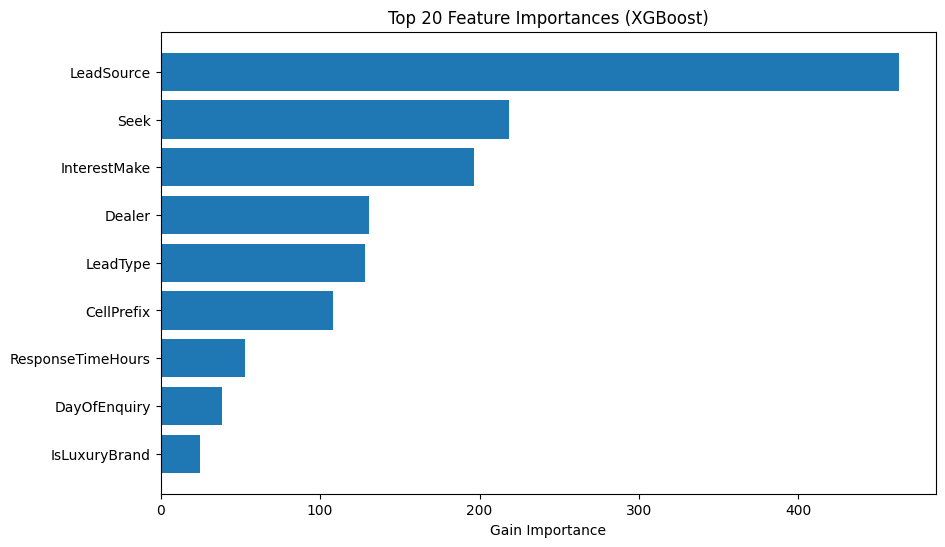

In [21]:

# Extract the underlying XGBoost model from the pipeline
xgb_model = model_pipeline.named_steps['modeling']

feature_names = TrainData.columns.tolist()

importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})


if importance_df['feature'].str.startswith('f').all():
    importance_df['feature'] = importance_df['feature'].apply(lambda x: feature_names[int(x[1:])])

# Sort by importance descending
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot top featurs
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'].head(20)[::-1], importance_df['importance'].head(20)[::-1])
plt.xlabel('Gain Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.show()


In [22]:
# # ── AFTER your model has generated predictions ─────────────────────────
# # Put your FINAL test-set DataFrame in `dfTest`
# #   • Must contain a column 'LeadID'
# # Put the probability vector in `probabilities`
# #   • One value per row of dfTest,  numeric 0‒1
# # You may compute them any way you like; just assign here ↓↓↓

# dfTest        = dfTest
# probabilities = y_pred

# # This MUST be your last cell. The section below is standardised to automatically enable us to score your output if we successfully run your notebook. 
# # Your notebook upload will not succeed if the below section is not found (as is).
# # -----------------------------------------------------------------------
# def save_submission(df: pd.DataFrame, probs: pd.Series | np.ndarray):
#     """
#     Writes the CSV exactly as the leaderboard expects.
#     """
#     out = pd.DataFrame(
#         {
#             "LeadID":                 df["LeadID"].values,
#             "VehicleSoldProbability": probs
#         }
#     )

#     # minimal sanity checks
#     assert len(out) == len(df),                "Length mismatch."
#     assert out["VehicleSoldProbability"].between(0, 1).all(), "Probs out of range."
#     assert out["LeadID"].is_unique,            "Duplicate LeadID values."
#     assert not out.isna().any().any(),         "NaNs detected."

#     fname = f"submission.csv"
#     out.to_csv(fname, index=False)

# save_submission(dfTest, probabilities)